In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
sys.executable

'/usr/bin/python3'

In [3]:
import torch
import torchvision
torch.__version__, torchvision.__version__

('1.10.1+cu102', '0.11.2+cu102')

In [4]:
from itertools import groupby
import numpy as np
import cv2
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
from pathlib import Path
import pickle5 as pickle

import shutil
import sys
sys.path.append("../src/")
sys.path.append("../yolov5/")

import util

from joblib import Parallel, delayed

from IPython.display import display, HTML

from matplotlib import animation, rc
rc('animation', html='jshtml')

In [5]:
CONF = 0.05
IOU = 0.4
AUGMENT = False
SIZE = 1280
#USE_CLACHE = True
USE_SAHI = False

# Data

In [6]:
meta_params = {}
for model_version in ['0111_yolov5l_fold0_new_hyp_remove_1',"0118_yolov5l_fold0_new_hyp_remove_1_Clahe",
                      '0118_yolov5l_fold0_new_hyp_remove_1_noClahe']:#, '0110_yolov5l_fold0_new_hyp_remove_noaug']:
    model_folder = Path(f"../output/{model_version}/")
    try:
        params_path = model_folder / "config" / "params.pkl"
        params = pickle.load(open(params_path, 'rb'))
    except:
        params_path = model_folder / "config" / "params.yaml"
        params = util.load_yaml(params_path)
    meta_params[model_version] = params

In [7]:
for model_version, params in meta_params.items():
    for key, val in params.items():
        if "dir" in key or "path" in key or "file" in key:
            params[key] = Path(val)
    meta_params[model_version] = params

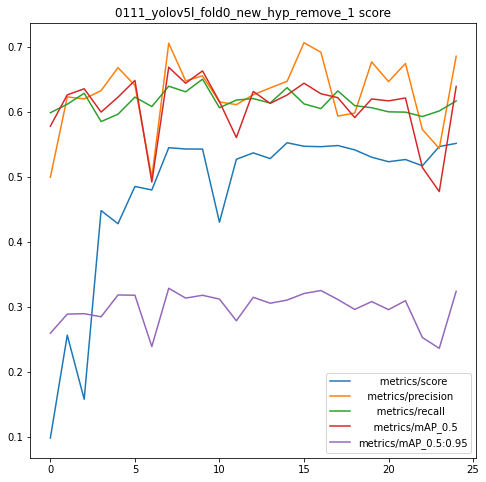

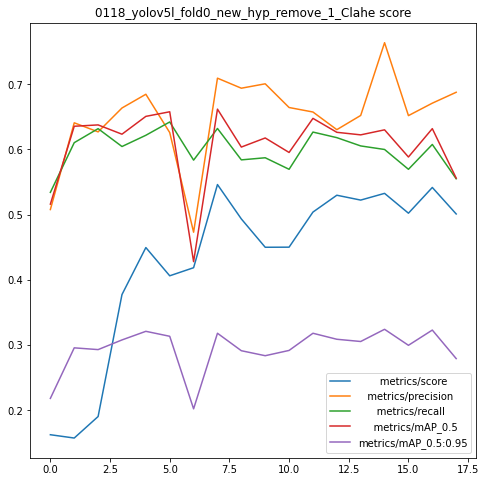

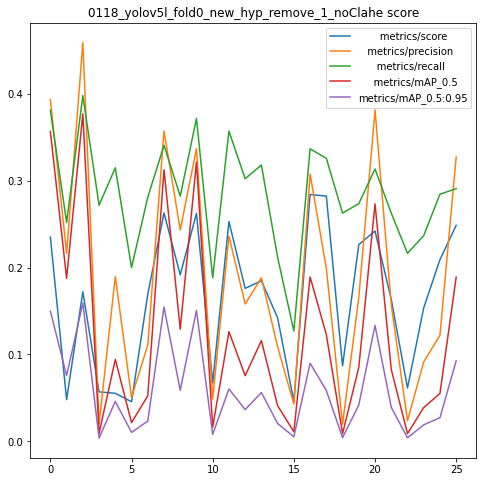

In [8]:
target_score = {}
for model_version, params in meta_params.items():
    logging_dir = params["ckpt_path"].parent.parent
    res_df = pd.read_csv(logging_dir / "results.csv")
    
    res_df[['       metrics/score','   metrics/precision', '      metrics/recall', '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', ]].plot(figsize=(8,8))
    plt.legend()
    plt.title(f"{model_version} score")
    plt.show()    
    
    target_score[model_version] = res_df['       metrics/score'].max()


In [9]:
target_score

{'0111_yolov5l_fold0_new_hyp_remove_1': 0.55289,
 '0118_yolov5l_fold0_new_hyp_remove_1_Clahe': 0.54622,
 '0118_yolov5l_fold0_new_hyp_remove_1_noClahe': 0.28389}

In [10]:
# Train Data
params_eg = list(meta_params.values())[0]
df = pd.read_csv(params_eg['data_path'] / 'train.csv')
df = df.progress_apply(lambda x: util.get_path(x, params_eg, infer=False), axis=1)
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df["real_bbox"] = df["annotations"].apply(lambda annots: [list(annot.values()) for annot in annots])
display(df.head(2))

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   

                                      old_image_path  \
0  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                          image_path  \
0  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                          label_path real_bbox  
0  /home/vincent/Kaggle/data/tensorflow-great-bar...        []  
1  /home/vincent/Kaggle/data/tensorflow-great-bar...        []

In [11]:
df.groupby("video_id").size()

video_id
0    6708
1    8232
2    8561
dtype: int64

In [12]:
# import itertools
# df_pos_1 = df[df["real_bbox"].apply(len) > 1]
# bboxes1_all = []
# bboxes2_all = []
# for i in range(len(df_pos_1)):
#     bboxes1 = np.array(list(itertools.combinations(df_pos_1["real_bbox"].iloc[i], 2)))[:,0,:]
#     bboxes2 = np.array(list(itertools.combinations(df_pos_1["real_bbox"].iloc[i], 2)))[:,1,:]
#     bboxes1_all.append(bboxes1)
#     bboxes2_all.append(bboxes2)    
# bboxes1_all = np.concatenate(bboxes1_all,0)
# bboxes2_all = np.concatenate(bboxes2_all,0)
# ious = util.calc_iou(bboxes1_all, bboxes2_all)
# np.diagonal(ious).max()

In [13]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


In [14]:
df["has_annotations"] = df["annotations"].apply(len) > 0

In [15]:
df.shape

(23501, 12)

In [16]:
23501 * 0.2093 # 5000 images with bbox

4918.759300000001

In [17]:
df.num_bbox.describe()

count    23501.000000
mean         0.506276
std          1.637906
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: num_bbox, dtype: float64

In [18]:
df.num_bbox.sum()

11898

In [19]:
df.sequence.unique()

array([40258, 45518, 59337,  8399, 45015, 35305, 53708,   996, 60510,
       44160, 15827, 29424,  8503, 18048, 17665, 60754, 37114, 26651,
       22643, 29859])

In [20]:
df.groupby("video_id")["sequence"].apply(lambda x:len(x.unique()))

video_id
0    8
1    8
2    4
Name: sequence, dtype: int64

# CV

## video_id

In [21]:
df["fold"] = df["video_id"]
df.groupby("fold").size()

fold
0    6708
1    8232
2    8561
dtype: int64

## subsequence

In [22]:
diff_place = (df["has_annotations"] + df["sequence"]).diff()
diff_place = diff_place.shift(-1)
diff_place.iloc[-1] = 1
diff_place_filter = diff_place[diff_place!=0] 
diff_place_filter[:] =1
subsequence_id_place = diff_place_filter.cumsum()
df["subsequence_id"] = np.nan
df.loc[subsequence_id_place.index, "subsequence_id"] = subsequence_id_place.values
df["subsequence_id"] = df["subsequence_id"].fillna(method="backfill")

In [23]:
df.groupby("subsequence_id")["has_annotations"].mean().value_counts()

0.0    75
1.0    64
Name: has_annotations, dtype: int64

In [24]:
df.groupby("subsequence_id").size().describe()

count     139.000000
mean      169.071942
std       343.814781
min         1.000000
25%        27.000000
50%        63.000000
75%       154.000000
max      2800.000000
dtype: float64

In [25]:
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
skf = StratifiedGroupKFold(n_splits=5)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (_, val_idx) in enumerate(skf.split(df, groups=df['subsequence_id'], y=df["has_annotations"])):
    df.loc[val_idx, 'fold'] = fold

In [26]:
df.fold.value_counts()

1    4702
3    4701
0    4700
4    4699
2    4699
Name: fold, dtype: int64

In [27]:
df.groupby("fold")["has_annotations"].mean()

fold
0    0.209362
1    0.209485
2    0.209193
3    0.209317
4    0.209193
Name: has_annotations, dtype: float64

In [28]:
df.query("num_bbox > 1")

video_id  sequence  video_frame  sequence_frame image_id  \
35            0     40258           35              35     0-35   
36            0     40258           36              36     0-36   
37            0     40258           37              37     0-37   
38            0     40258           38              38     0-38   
39            0     40258           39              39     0-39   
...         ...       ...          ...             ...      ...   
20162         2     22643         6260             897   2-6260   
20163         2     22643         6261             898   2-6261   
20164         2     22643         6262             899   2-6262   
20165         2     22643         6263             900   2-6263   
20166         2     22643         6264             901   2-6264   

                                             annotations  \
35     [{'x': 520, 'y': 151, 'width': 78, 'height': 6...   
36     [{'x': 520, 'y': 148, 'width': 80, 'height': 6...   
37     [{'x': 521, 'y': 144, 'width': 82, 'height': 6...   
38     [{'x': 522, 'y': 141, 'width': 83, 'height': 6...   
39     [{'x': 521, 'y': 139, 'width': 85, 'height': 6...   
...                                                  ...   
20162  [{'x': 503, 'y': 497, 'width': 36, 'height': 3...   
20163  [{'x': 503, 'y': 536, 'width': 36, 'height': 3...   
20164  [{'x': 504, 'y': 574, 'width': 36, 'height': 3...   
20165  [{'x': 502, 'y': 611, 'width': 36, 'height': 3...   
20166  [{'x': 500, 'y': 647, 'width': 36, 'height': 3...   

                                          old_image_path  \
35     /home/vincent/Kaggle/data/tensorflow-great-bar...   
36     /home/vincent/Kaggle/data/tensorflow-great-bar...   
37     /home/vincent/Kaggle/data/tensorflow-great-bar...   
38     /home/vincent/Kaggle/data/tensorflow-great-bar...   
39     /home/vincent/Kaggle/data/tensorflow-great-bar...   
...                                                  ...   
20162  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20163  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20164  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20165  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20166  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                              image_path  \
35     /home/vincent/Kaggle/data/tensorflow-great-bar...   
36     /home/vincent/Kaggle/data/tensorflow-great-bar...   
37     /home/vincent/Kaggle/data/tensorflow-great-bar...   
38     /home/vincent/Kaggle/data/tensorflow-great-bar...   
39     /home/vincent/Kaggle/data/tensorflow-great-bar...   
...                                                  ...   
20162  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20163  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20164  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20165  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20166  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                              label_path  \
35     /home/vincent/Kaggle/data/tensorflow-great-bar...   
36     /home/vincent/Kaggle/data/tensorflow-great-bar...   
37     /home/vincent/Kaggle/data/tensorflow-great-bar...   
38     /home/vincent/Kaggle/data/tensorflow-great-bar...   
39     /home/vincent/Kaggle/data/tensorflow-great-bar...   
...                                                  ...   
20162  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20163  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20164  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20165  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20166  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                               real_bbox  num_bbox  \
35              [[520, 151, 78, 62], [598, 204, 58, 32]]         2   
36              [[520, 148, 80, 63], [598, 206, 61, 34]]         2   
37              [[521, 144, 82, 65], [599, 208, 64, 36]]         2   
38              [[522, 141, 83, 67], [

In [29]:
df.query("has_annotations").groupby("fold").size()

fold
0    984
1    985
2    983
3    984
4    983
dtype: int64

In [30]:
df.groupby("fold")["subsequence_id"].apply(np.unique).apply(len)

fold
0    26
1    28
2    27
3    29
4    29
Name: subsequence_id, dtype: int64

In [31]:
df.groupby("fold").size()

fold
0    4700
1    4702
2    4699
3    4701
4    4699
dtype: int64

In [32]:
df.query("has_annotations").groupby("fold").size()

fold
0    984
1    985
2    983
3    984
4    983
dtype: int64

# Model Prediction Analysis

In [33]:
for params in meta_params.values():
    params["repo"] = Path("../yolov5/").resolve()
    params["augment"]  = AUGMENT
    params["conf"] = CONF
    params["iou"] = IOU

In [34]:
df_oof = df.query("fold == 0").copy()
df_oof

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0             0     40258            0               0      0-0          []   
1             0     40258            1               1      0-1          []   
2             0     40258            2               2      0-2          []   
3             0     40258            3               3      0-3          []   
4             0     40258            4               4      0-4          []   
...         ...       ...          ...             ...      ...         ...   
20701         2     29859         7960             188   2-7960          []   
20702         2     29859         7961             189   2-7961          []   
20703         2     29859         7962             190   2-7962          []   
20704         2     29859         7963             191   2-7963          []   
20705         2     29859         7964             192   2-7964          []   

                                          old_image_path  \
0      /home/vincent/Kaggle/data/tensorflow-great-bar...   
1      /home/vincent/Kaggle/data/tensorflow-great-bar...   
2      /home/vincent/Kaggle/data/tensorflow-great-bar...   
3      /home/vincent/Kaggle/data/tensorflow-great-bar...   
4      /home/vincent/Kaggle/data/tensorflow-great-bar...   
...                                                  ...   
20701  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20702  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20703  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20704  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20705  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                              image_path  \
0      /home/vincent/Kaggle/data/tensorflow-great-bar...   
1      /home/vincent/Kaggle/data/tensorflow-great-bar...   
2      /home/vincent/Kaggle/data/tensorflow-great-bar...   
3      /home/vincent/Kaggle/data/tensorflow-great-bar...   
4      /home/vincent/Kaggle/data/tensorflow-great-bar...   
...                                                  ...   
20701  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20702  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20703  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20704  /home/vincent/Kaggle/data/tensorflow-great-bar...   
20705  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                              label_path real_bbox  num_bbox  \
0      /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
1      /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
2      /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
3      /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
4      /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
...                                                  ...       ...       ...   
20701  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
20702  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
20703  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
20704  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
20705  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   

       has_annotations  fold  subsequence_id  
0                False     0             1.0  
1                False     0             1.0  
2                False     0             1.0  
3                False     0             1.0  
4                False     0             1.0  
...                ...   ...             ...  
20701            False     0           133.0  
20702            False     0           133.0  
20703            False     0           133.0  
20704            False     0           133.0  
20705            False     0           133.0  

[4700 rows x 14 columns]

## SAHI

In [35]:
from sahi.model import Yolov5DetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict

from IPython.display import Image

In [36]:
# path = "/home/vincent/Kaggle/Kaggle_TGBR/input/l6_3600_uflip_vm5_f12_up/f1/best.pt"
# detection_model = Yolov5DetectionModel(
#     model_path=path,
#     confidence_threshold=0.1,
#     image_size = 1280,
#     device="cuda:1", # or 'cuda:0'
# )

In [37]:
# df_oof.columns

In [38]:
# path = str(df_oof.query("num_bbox > 5")['image_path'].iloc[2])
# result = get_prediction(path, detection_model)
# result_sliced = get_sliced_prediction(
#     path,
#     detection_model,
#     slice_height = 256,
#     slice_width = 256,
#     overlap_height_ratio = 0.2,
#     overlap_width_ratio = 0.2
# )

In [39]:
# img = cv2.imread(str(path))[...,::-1]
# result_3 = get_prediction(img, detection_model)

# result_3.export_visuals(export_dir="demo_data/test/")

# Image("demo_data/test/prediction_visual.png")

In [40]:
# result.export_visuals(export_dir="demo_data/no_slice/")
# result_sliced.export_visuals(export_dir="demo_data/")

# Image("demo_data/no_slice/prediction_visual.png")

In [41]:
# Image("demo_data/prediction_visual.png")

In [42]:
# object_prediction_list = result_sliced.object_prediction_list
# object_prediction_list

In [43]:
# object_prediction_list[0].score.value

In [44]:
# result_sliced.object_prediction_list[0].bbox

In [45]:
# result_sliced.object_prediction_list[0].bbox.to_coco_bbox
# result_sliced.object_prediction_list[0].score.value

## Normal

In [46]:
def load_special_model():
    path = "/home/vincent/Kaggle/Kaggle_TGBR/input/l6_3600_uflip_vm5_f12_up/f1/best.pt"    
    model = torch.hub.load(params['repo'],
                           'custom',
                           path=path,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = 0.01  # NMS confidence threshold
    return model

In [47]:
models = {}
for model_version, params in meta_params.items():
    if USE_SAHI:
        model = Yolov5DetectionModel(
            model_path=str(params['ckpt_path']),
            confidence_threshold=params['conf'],
            image_size = params['img_size'],
            device="cuda:0", # or 'cuda:0'
        )    
    else:
        model = util.load_model(params)
        device = torch.device("cuda")
        model.to(device)
    models[model_version] = model
    
    #model = load_special_model()
    #models['special'] = model

YOLOv5 🚀 v6.0-186-ge20e1f0 torch 1.10.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11016MiB)

Fusing layers... 
Model Summary: 367 layers, 46108278 parameters, 0 gradients, 107.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 v6.0-186-ge20e1f0 torch 1.10.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11016MiB)

Fusing layers... 
Model Summary: 367 layers, 46108278 parameters, 0 gradients, 107.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 v6.0-186-ge20e1f0 torch 1.10.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11016MiB)

Fusing layers... 
Model Summary: 367 layers, 46108278 parameters, 0 gradients, 107.8 GFLOPs
Adding AutoShape... 


In [48]:
df_oof["pred_bbox"] = None
df_oof["pred_confs"] = None
for model_version in models.keys():
    df_oof["pred_bbox_" + model_version] = None
    df_oof["pred_confs_" + model_version] = None

In [49]:
df_oof.columns

Index(['video_id', 'sequence', 'video_frame', 'sequence_frame', 'image_id',
       'annotations', 'old_image_path', 'image_path', 'label_path',
       'real_bbox', 'num_bbox', 'has_annotations', 'fold', 'subsequence_id',
       'pred_bbox', 'pred_confs',
       'pred_bbox_0111_yolov5l_fold0_new_hyp_remove_1',
       'pred_confs_0111_yolov5l_fold0_new_hyp_remove_1',
       'pred_bbox_0118_yolov5l_fold0_new_hyp_remove_1_Clahe',
       'pred_confs_0118_yolov5l_fold0_new_hyp_remove_1_Clahe',
       'pred_bbox_0118_yolov5l_fold0_new_hyp_remove_1_noClahe',
       'pred_confs_0118_yolov5l_fold0_new_hyp_remove_1_noClahe'],
      dtype='object')

In [50]:
df_oof.reset_index(inplace=True, drop=True)

In [51]:
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(14, 14))
for idx in tqdm(range(len(df_oof))):
    row = df_oof.loc[idx]
    img_path = row["image_path"]
    img = cv2.imread(str(img_path))[...,::-1]
    for model_version, model in models.items():
        USE_CLACHE = meta_params[model_version].get("use_clahe", True)
        img2 = img.copy()
        if USE_CLACHE:
            for i in range(3):
                img2[:, :, i] = clahe.apply((img2[:, :, i]))     
        pred_bbox, confs = util.predict(model, img2, size=SIZE, augment=AUGMENT, use_sahi=USE_SAHI)
        df_oof.at[idx, "pred_bbox_" + model_version] = pred_bbox.tolist()
        df_oof.at[idx, "pred_confs_" + model_version] = confs

  0%|          | 0/4700 [00:00<?, ?it/s]

In [52]:
from ensemble_boxes import weighted_boxes_fusion

In [53]:
def run_wbf(bboxes, confs, image_size=1280, iou_thr=0.4, skip_box_thr=0.7, weights=None, conf_type='avg'):
    if len(bboxes) == 1:
        return bboxes[0], confs[0], []    
    boxes =  [bbox / (image_size-1) for bbox in bboxes]
    scores = [conf for conf in confs]    
    labels = [np.ones(len(conf)) for conf in confs]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr,conf_type=conf_type)
    boxes = boxes * (image_size-1)
    return boxes, scores, labels

In [66]:
# thr_s = []
# for iou_thr in range(1, 8):
#     iou_thr /= 10
#     for skip_box_thr in range(1,8):
#         skip_box_thr /= 10
#         gt_bboxs_list = []
#         prd_bboxs_list = []
#         df_oof_pos = df_oof.query("num_bbox > 0")
#         for idx in tqdm(range(len(df_oof))):
#             row = df_oof.iloc[idx]
#             gt_bboxs = row["real_bbox"]
#             gt_bboxs_list.append(np.array(gt_bboxs))
#             prd_bboxs_all = []
#             confis_all = []
#             for model_version in models.keys():
#                 bboxes, confis = row["pred_bbox_" + model_version], row["pred_confs_" + model_version]
#                 bboxes = np.array(bboxes)
#                 confis = np.array(confis)
#                 if len(confis) > 0:
#                     # xywh to xyxy
#                     bboxes[:,2:] = bboxes[:,:2] + bboxes[:,2:]
#                     prd_bboxs_all.append(bboxes)
#                     confis_all.append(confis)
#             if len(prd_bboxs_all) > 0:
#                 bboxes, confis, labels = run_wbf(prd_bboxs_all, confis_all, conf_type="avg", iou_thr=iou_thr, skip_box_thr=skip_box_thr)
#                 # xyxy to xywh
#                 if len(bboxes) > 0:
#                     wh = bboxes[:,2:] - bboxes[:,:2]
#                     bboxes[:,2:] = wh
#                 bboxes = bboxes.tolist()
#                 confis = confis.tolist()
#             else:
#                 bboxes, confis = [], []    
#             df_oof.at[idx, "pred_bbox"] = bboxes
#             df_oof.at[idx, "pred_confs"] = confis
#             prd_bboxs = [[confis[i]] + bboxes[i] for i in range(len(confis))]
#             prd_bboxs_list.append(np.array(prd_bboxs))

#         iou_ths = np.arange(0.3, 0.85, 0.05)
#         score = np.mean([calculate_score(prd_bboxs_list, gt_bboxs_list, iou_th) for iou_th in iou_ths])
#         tps, fps, fns = util.calc_f2_score(gt_bboxs_list, prd_bboxs_list, verbose=False)
#         df_oof["tp"], df_oof["fp"], df_oof["fn"] = tps, fps, fns    
#         score_2 = util.f_beta(*df_oof[["tp", "fp", "fn"]].sum(axis=0), beta=2) 
#         score_only_bbox =  util.f_beta(*df_oof.query("has_annotations")[["tp", "fp", "fn"]].sum(axis=0), beta=2) 
#         thr_s.append([iou_thr, skip_box_thr, score])
#         print(f"iou_thr {iou_thr}, skip_box_thr {skip_box_thr}: f2 method 1 {score:.4f},  method 2 {score_2:.4f}, score only consider those with bbox: {score_only_bbox:.4f}")

  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.1, skip_box_thr 0.1: f2 method 1 0.5207,  method 2 0.5243, score only consider those with bbox: 0.6091


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.1, skip_box_thr 0.2: f2 method 1 0.5255,  method 2 0.5294, score only consider those with bbox: 0.6070


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.1, skip_box_thr 0.3: f2 method 1 0.5233,  method 2 0.5272, score only consider those with bbox: 0.6001


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.1, skip_box_thr 0.4: f2 method 1 0.5155,  method 2 0.5195, score only consider those with bbox: 0.5894


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.1, skip_box_thr 0.5: f2 method 1 0.5064,  method 2 0.5100, score only consider those with bbox: 0.5774


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.1, skip_box_thr 0.6: f2 method 1 0.4974,  method 2 0.5012, score only consider those with bbox: 0.5663


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.1, skip_box_thr 0.7: f2 method 1 0.4722,  method 2 0.4757, score only consider those with bbox: 0.5368


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.2, skip_box_thr 0.1: f2 method 1 0.5396,  method 2 0.5431, score only consider those with bbox: 0.6306


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.2, skip_box_thr 0.2: f2 method 1 0.5440,  method 2 0.5478, score only consider those with bbox: 0.6278


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.2, skip_box_thr 0.3: f2 method 1 0.5415,  method 2 0.5454, score only consider those with bbox: 0.6205


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.2, skip_box_thr 0.4: f2 method 1 0.5319,  method 2 0.5359, score only consider those with bbox: 0.6078


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.2, skip_box_thr 0.5: f2 method 1 0.5222,  method 2 0.5259, score only consider those with bbox: 0.5952


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.2, skip_box_thr 0.6: f2 method 1 0.5102,  method 2 0.5139, score only consider those with bbox: 0.5805


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.2, skip_box_thr 0.7: f2 method 1 0.4793,  method 2 0.4828, score only consider those with bbox: 0.5448


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.3, skip_box_thr 0.1: f2 method 1 0.5481,  method 2 0.5512, score only consider those with bbox: 0.6399


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.3, skip_box_thr 0.2: f2 method 1 0.5525,  method 2 0.5561, score only consider those with bbox: 0.6371


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.3, skip_box_thr 0.3: f2 method 1 0.5492,  method 2 0.5528, score only consider those with bbox: 0.6289


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.3, skip_box_thr 0.4: f2 method 1 0.5387,  method 2 0.5426, score only consider those with bbox: 0.6152


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.3, skip_box_thr 0.5: f2 method 1 0.5277,  method 2 0.5311, score only consider those with bbox: 0.6011


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.3, skip_box_thr 0.6: f2 method 1 0.5158,  method 2 0.5192, score only consider those with bbox: 0.5865


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.3, skip_box_thr 0.7: f2 method 1 0.4816,  method 2 0.4852, score only consider those with bbox: 0.5474


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.4, skip_box_thr 0.1: f2 method 1 0.5478,  method 2 0.5507, score only consider those with bbox: 0.6393


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.4, skip_box_thr 0.2: f2 method 1 0.5528,  method 2 0.5562, score only consider those with bbox: 0.6372


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.4, skip_box_thr 0.3: f2 method 1 0.5496,  method 2 0.5532, score only consider those with bbox: 0.6293


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.4, skip_box_thr 0.4: f2 method 1 0.5389,  method 2 0.5428, score only consider those with bbox: 0.6154


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.4, skip_box_thr 0.5: f2 method 1 0.5276,  method 2 0.5311, score only consider those with bbox: 0.6010


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.4, skip_box_thr 0.6: f2 method 1 0.5157,  method 2 0.5192, score only consider those with bbox: 0.5864


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.4, skip_box_thr 0.7: f2 method 1 0.4816,  method 2 0.4852, score only consider those with bbox: 0.5474


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.5, skip_box_thr 0.1: f2 method 1 0.5470,  method 2 0.5500, score only consider those with bbox: 0.6386


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.5, skip_box_thr 0.2: f2 method 1 0.5522,  method 2 0.5556, score only consider those with bbox: 0.6366


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.5, skip_box_thr 0.3: f2 method 1 0.5493,  method 2 0.5528, score only consider those with bbox: 0.6288


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.5, skip_box_thr 0.4: f2 method 1 0.5388,  method 2 0.5426, score only consider those with bbox: 0.6151


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.5, skip_box_thr 0.5: f2 method 1 0.5275,  method 2 0.5310, score only consider those with bbox: 0.6009


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.5, skip_box_thr 0.6: f2 method 1 0.5156,  method 2 0.5191, score only consider those with bbox: 0.5863


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.5, skip_box_thr 0.7: f2 method 1 0.4816,  method 2 0.4852, score only consider those with bbox: 0.5474


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.6, skip_box_thr 0.1: f2 method 1 0.5459,  method 2 0.5489, score only consider those with bbox: 0.6372


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.6, skip_box_thr 0.2: f2 method 1 0.5516,  method 2 0.5549, score only consider those with bbox: 0.6356


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.6, skip_box_thr 0.3: f2 method 1 0.5491,  method 2 0.5525, score only consider those with bbox: 0.6284


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.6, skip_box_thr 0.4: f2 method 1 0.5387,  method 2 0.5424, score only consider those with bbox: 0.6148


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.6, skip_box_thr 0.5: f2 method 1 0.5274,  method 2 0.5308, score only consider those with bbox: 0.6006


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.6, skip_box_thr 0.6: f2 method 1 0.5156,  method 2 0.5191, score only consider those with bbox: 0.5863


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.6, skip_box_thr 0.7: f2 method 1 0.4816,  method 2 0.4851, score only consider those with bbox: 0.5473


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.7, skip_box_thr 0.1: f2 method 1 0.5437,  method 2 0.5467, score only consider those with bbox: 0.6345


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.7, skip_box_thr 0.2: f2 method 1 0.5502,  method 2 0.5534, score only consider those with bbox: 0.6337


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.7, skip_box_thr 0.3: f2 method 1 0.5480,  method 2 0.5515, score only consider those with bbox: 0.6269


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.7, skip_box_thr 0.4: f2 method 1 0.5377,  method 2 0.5415, score only consider those with bbox: 0.6136


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.7, skip_box_thr 0.5: f2 method 1 0.5266,  method 2 0.5301, score only consider those with bbox: 0.5996


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.7, skip_box_thr 0.6: f2 method 1 0.5149,  method 2 0.5184, score only consider those with bbox: 0.5853


  0%|          | 0/4700 [00:00<?, ?it/s]

iou_thr 0.7, skip_box_thr 0.7: f2 method 1 0.4815,  method 2 0.4848, score only consider those with bbox: 0.5469


In [67]:
gt_bboxs_list = []
prd_bboxs_list = []
df_oof_pos = df_oof.query("num_bbox > 0")
for idx in tqdm(range(len(df_oof))):
    row = df_oof.iloc[idx]
    gt_bboxs = row["real_bbox"]
    gt_bboxs_list.append(np.array(gt_bboxs))
    prd_bboxs_all = []
    confis_all = []
    for model_version in models.keys():
        bboxes, confis = row["pred_bbox_" + model_version], row["pred_confs_" + model_version]
        bboxes = np.array(bboxes)
        confis = np.array(confis)
        if len(confis) > 0:
            # xywh to xyxy
            bboxes[:,2:] = bboxes[:,:2] + bboxes[:,2:]
            prd_bboxs_all.append(bboxes)
            confis_all.append(confis)
    if len(prd_bboxs_all) > 0:
        bboxes, confis, labels = run_wbf(prd_bboxs_all, confis_all, conf_type="avg", iou_thr=0.4, skip_box_thr=0.2)
        # xyxy to xywh
        if len(bboxes) > 0:
            wh = bboxes[:,2:] - bboxes[:,:2]
            bboxes[:,2:] = wh
        bboxes = bboxes.tolist()
        confis = confis.tolist()
    else:
        bboxes, confis = [], []    
    df_oof.at[idx, "pred_bbox"] = bboxes
    df_oof.at[idx, "pred_confs"] = confis
    prd_bboxs = [[confis[i]] + bboxes[i] for i in range(len(confis))]
    prd_bboxs_list.append(np.array(prd_bboxs))

  0%|          | 0/4700 [00:00<?, ?it/s]

In [68]:
from torchvision.ops import box_iou
def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 2:] = x[:, :2] + x[:, 2:]
    return y

def calculate_score(preds, gts,iou_th):
    num_tp = 0
    num_fp = 0
    num_fn = 0
    for p, gt in zip(preds, gts):
        if len(p) and len(gt):
            confs = p[:,0].argsort()
            iou_matrix = box_iou(torch.from_numpy(xywh2xyxy(p[:,1:])).int(), torch.from_numpy(xywh2xyxy(gt)).int())
            for i, idx in enumerate(confs):
                if iou_matrix.shape[1] == 0:
                    num_fp += len(confs) - i
                    break
                if iou_matrix[idx, :].max(0)[0] >= iou_th:
                    num_tp += 1
                    idxx = iou_matrix[idx, :].argmax()
                    iou_matrix = torch.cat((iou_matrix[:,:idxx], iou_matrix[:,idxx+1:]),dim=1)
                else:
                    num_fp += 1
            num_fn += iou_matrix.shape[1]
        elif len(p) == 0 and len(gt):
            num_fn += len(gt)
        elif len(p) and len(gt) == 0:
            num_fp += len(p)
            
    score = 5 * num_tp / (5 * num_tp + 4 * num_fn + num_fp)
    return score

In [69]:
target_score

{'0111_yolov5l_fold0_new_hyp_remove_1': 0.55289,
 '0118_yolov5l_fold0_new_hyp_remove_1_Clahe': 0.54622,
 '0118_yolov5l_fold0_new_hyp_remove_1_noClahe': 0.28389}

In [70]:
iou_ths = np.arange(0.3, 0.85, 0.05)
for model_version in tqdm(list(models.keys()) + ["wbf"]):
    if model_version == "wbf":
        pred_col = "pred_bbox"
        conf_col = "pred_confs"
    else:
        pred_col = "pred_bbox" + "_" + model_version
        conf_col = "pred_confs" + "_" + model_version
    prd_bboxs_list = []
    for index in df_oof.index:
        confis = df_oof.loc[index, conf_col]
        bboxes = df_oof.loc[index, pred_col]
        prd_bboxs = [[confis[i]] + bboxes[i] for i in range(len(confis))]
        prd_bboxs_list.append(np.array(prd_bboxs))
    score = np.mean([calculate_score(prd_bboxs_list, gt_bboxs_list, iou_th) for iou_th in iou_ths])
    
    tps, fps, fns = util.calc_f2_score(gt_bboxs_list, prd_bboxs_list, verbose=False)
    df_oof["tp"], df_oof["fp"], df_oof["fn"] = tps, fps, fns    
    score_2 = util.f_beta(*df_oof[["tp", "fp", "fn"]].sum(axis=0), beta=2) 
    score_only_bbox =  util.f_beta(*df_oof.query("has_annotations")[["tp", "fp", "fn"]].sum(axis=0), beta=2) 
    print(f"{model_version}: f2 method 1 {score:.4f},  method 2 {score_2:.4f}, score only consider those with bbox: {score_only_bbox:.4f}")

  0%|          | 0/4 [00:00<?, ?it/s]

0111_yolov5l_fold0_new_hyp_remove_1: f2 method 1 0.5512,  method 2 0.5513, score only consider those with bbox: 0.5912
0118_yolov5l_fold0_new_hyp_remove_1_Clahe: f2 method 1 0.5419,  method 2 0.5419, score only consider those with bbox: 0.5838
0118_yolov5l_fold0_new_hyp_remove_1_noClahe: f2 method 1 0.5613,  method 2 0.5613, score only consider those with bbox: 0.5971
wbf: f2 method 1 0.5528,  method 2 0.5562, score only consider those with bbox: 0.6372


In [71]:
a = {3:2}
a.3

SyntaxError: invalid syntax (448324154.py, line 2)

1. augment=False, conf=0.15, iou=0.5: 0.421, 0.427
2. augment=True, conf=0.15, iou=0.5: 0.444, 0.454
3. augment=True, conf=0, iou=0.5: 0.002, 0.008
4. augment=True, conf=0.15, iou=0.7: 0.442, 0.452
5. augment=True, conf=0.1, iou=0.7: 0.448, 0.463
6. augment=True, conf=0.1, iou=0.6: 0.451, 0.466
7. augment=True, conf=0.1, iou=0.5: 0.451, 0.467
8. **augment=True, conf=0.05, iou=0.4, small**: 0.452, 0.480
9. **augment=True, conf=0.05, iou=0.4, large**: 0.435, 0.445
10. **augment=True, conf=0.05, iou=0.4, large**: CV:0.6134, 0.471, 0.593
11. **augment=True, conf=0.05, iou=0.4, small clahe**: CV:0.48309, 0.453, 0.524
12. **small, augment=True, conf=0.05, iou=0.4, new hyp**: CV:0.488, 0.512, 0.541
13. **small, augment=True, conf=0.05, iou=0.4, new hyp**: CV:0.567, 0.542, 0.587
14. 0110_yolov5l_fold0_new_hyp_remove_noaug: CV 0.527, 0.508, 0.563 LB:0.425
15. 0111_yolov5l_fold0_new_hyp_remove_1: CV 0.553, 0.551, 0.591, LB:0.487

In [81]:
color_pred = [(0,255,0)]    
color_real = [(255,0,0)]
def plot_img(df, idx):
    row = df.loc[idx]
    path = row["image_path"]
    img = cv2.imread(str(path))[...,::-1]
    real_bboxes, bboxes, confis = row["real_bbox"], row["pred_bbox"], row["pred_confs"]
    display(util.show_img(img, 
                          bboxes + real_bboxes, 
                          color_pred + color_real, 
                          bbox_format='coco', 
                          labels= [0]*len(bboxes) + [1] * len(real_bboxes))
    )

## Most FN

In [82]:
most_fn = df_oof.sort_values("fn", ascending=False).head()
most_fn

video_id  sequence  video_frame  sequence_frame image_id  ...  \
1147         1      8503         4176             348   1-4176  ...   
1144         1      8503         4173             345   1-4173  ...   
1130         1      8503         4159             331   1-4159  ...   
1146         1      8503         4175             347   1-4175  ...   
1148         1      8503         4177             349   1-4177  ...   

      pred_bbox_0110_yolov5l_fold0_new_hyp_remove_noaug  \
1147  [[221, 281, 60, 49], [723, 388, 61, 56], [616,...   
1144  [[248, 287, 54, 44], [741, 373, 59, 59], [625,...   
1130  [[281, 236, 51, 40], [738, 288, 58, 55], [643,...   
1146  [[231, 281, 58, 46], [729, 382, 61, 57], [622,...   
1148  [[214, 283, 58, 48], [719, 396, 59, 55], [608,...   

     pred_confs_0110_yolov5l_fold0_new_hyp_remove_noaug  tp  fp   fn  
1147  [0.881048321723938, 0.8437702059745789, 0.8404...  39   5  104  
1144  [0.8876953125, 0.8396775126457214, 0.793804943...  40   4  103  
1130  [0.8861092925071716, 0.8451812863349915, 0.832...  31  13  101  
1146  [0.8793126344680786, 0.8570876717567444, 0.763...  45  10   98  
1148  [0.8996800780296326, 0.8420591354370117, 0.839...  46   9   97  

[5 rows x 23 columns]

In [83]:
most_fn["pred_bbox_0110_yolov5l_fold0_new_hyp_remove_noaug"]

1147    [[221, 281, 60, 49], [723, 388, 61, 56], [616,...
1144    [[248, 287, 54, 44], [741, 373, 59, 59], [625,...
1130    [[281, 236, 51, 40], [738, 288, 58, 55], [643,...
1146    [[231, 281, 58, 46], [729, 382, 61, 57], [622,...
1148    [[214, 283, 58, 48], [719, 396, 59, 55], [608,...
Name: pred_bbox_0110_yolov5l_fold0_new_hyp_remove_noaug, dtype: object

In [86]:
most_fn["pred_bbox"].iloc[0]

[[220.5111275166273,
  280.99998934566975,
  60.488861829042435,
  48.51113186776638],
 [615.0051821172237, 555.9999930262566, 37.49742326140404, 37.49742326140404],
 [722.5086004137993, 386.525602966547, 61.982940554618835, 56.49147605895996],
 [606.0, 231.99999999999997, 45.0, 46.00000000000003]]

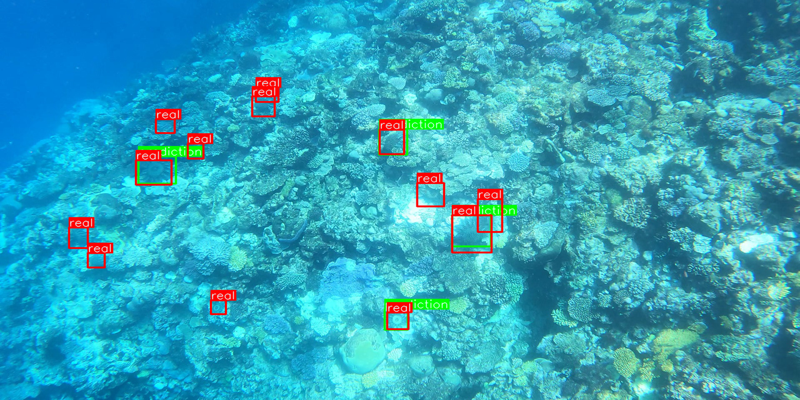

In [85]:
plot_img(df_oof, most_fn.index[0])

## Most FP

In [64]:
most_fp = df_oof.sort_values("fp", ascending=False).head()
most_fp

video_id  sequence  video_frame  sequence_frame image_id  ...  \
1151         1      8503         4180             352   1-4180  ...   
2789         2     37114         1207            1207   2-1207  ...   
2787         2     37114         1205            1205   2-1205  ...   
3795         2     37114         2213            2213   2-2213  ...   
1690         2     37114          108             108    2-108  ...   

      pred_bbox_0110_yolov5l_fold0_new_hyp_remove_noaug  \
1151  [[702, 424, 61, 57], [187, 293, 63, 50], [587,...   
2789  [[570, 0, 138, 196], [506, 0, 139, 189], [507,...   
2787  [[502, 0, 136, 194], [570, 0, 140, 195], [439,...   
3795       [[660, 446, 152, 212], [749, 461, 166, 200]]   
1690                                                 []   

     pred_confs_0110_yolov5l_fold0_new_hyp_remove_noaug  tp  fp  fn  
1151  [0.8776167631149292, 0.8728437423706055, 0.842...  50  27  93  
2789  [0.9107427000999451, 0.8831813931465149, 0.551...   0  22   0  
2787  [0.89026939868927, 0.8858252167701721, 0.65977...   0  22   0  
3795           [0.8844916224479675, 0.7065191864967346]   0  22   0  
1690                                                 []   0  22   0  

[5 rows x 23 columns]

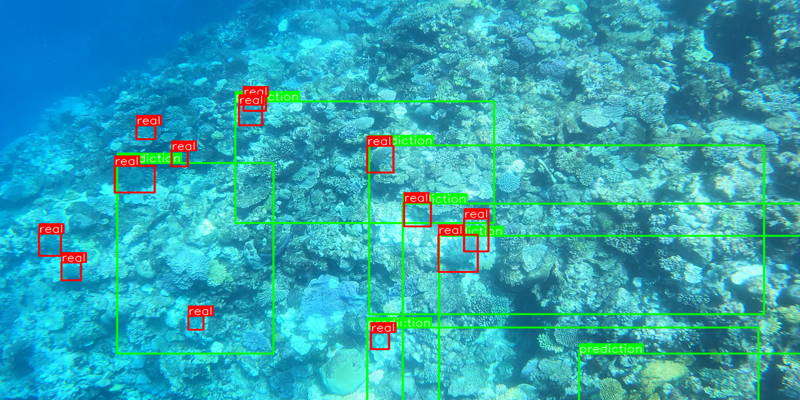

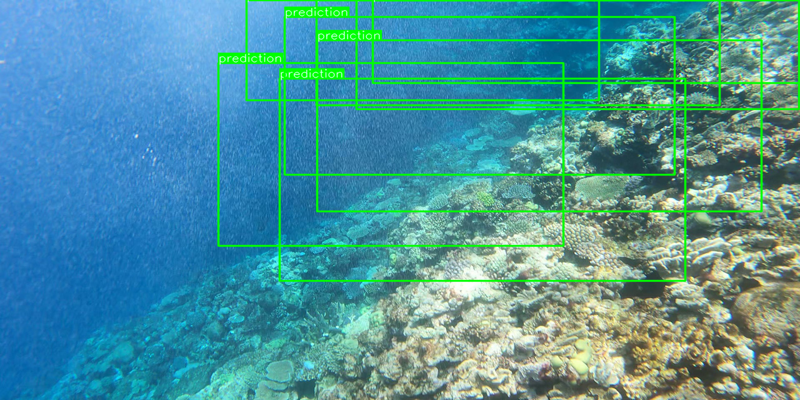

In [65]:
plot_img(df_oof, most_fp.index[0])
plot_img(df_oof, most_fp.index[1])

## Most TP

In [66]:
most_tp = df_oof.sort_values("tp", ascending=False).head()

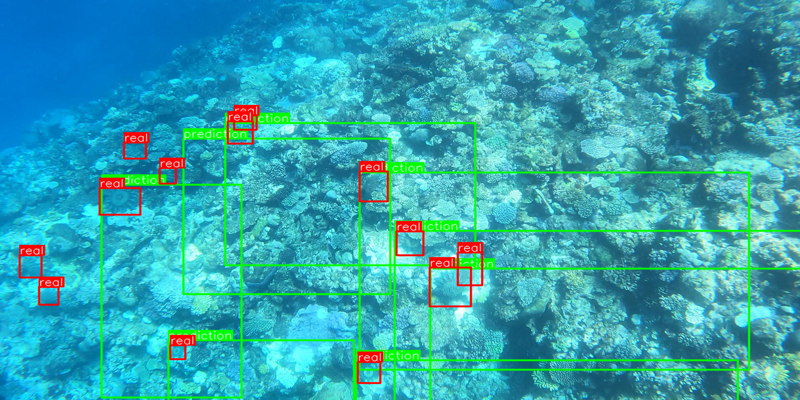

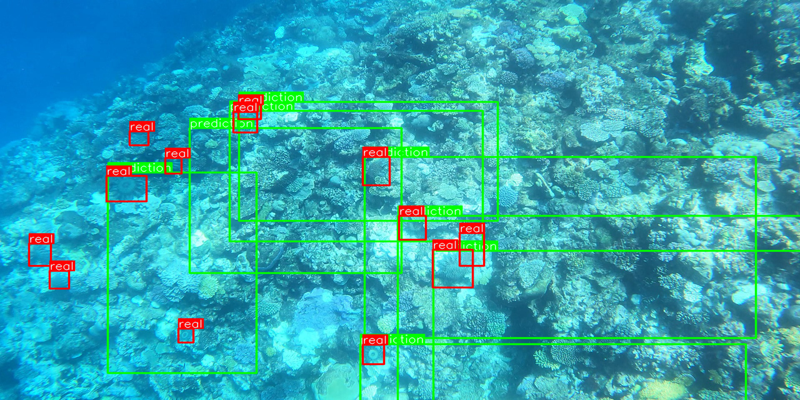

In [67]:
plot_img(df_oof, most_tp.index[0])
plot_img(df_oof, most_tp.index[1])